In [25]:
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import humanize
import matplotlib.pyplot as plt
import numpy as np

from helpers import *

@FuncFormatter
def duration_fmt(x, pos):
    return humanize.precisedelta(x, minimum_unit='minutes',format='%0.0f')


### plot precision and recall

In [26]:
fname_pr_results = "../../results/distance_varyparams/performance_measures/global/csv_files/pr_results.csv"
fname_mds = "../../results/distance_varyparams/performance_measures/global/mds_results_subset.csv.gz"

In [27]:
df = pd.read_csv(fname_pr_results)
df_mds = pd.read_csv(fname_mds)

In [28]:
df.loc[:,'haplos'] = df['params'].str.split('~').str[7].str.split('\n').str[0]
df_mds.loc[:,'haplos'] = df_mds['params'].str.split('~').str[7].str.split('\n').str[0]

def f_haplo2population(row):
    if row["haplos"] == '10@20@200@50@20@geom@0.75':
        return "Population 3"
    if row["haplos"] == '10@20@400@100@100@geom@0.75':
        return "Population 4"
    if row["haplos"] == '5@50@200@50@20@geom@0.75':
        return "Population 5"
    if row["haplos"] == '5@5@200@50@20@geom@0.75':
        return "Population 1"
    if row["haplos"] == '5@50@400@100@100@geom@0.75':
        return "Population 6"
    if row["haplos"] == '5@5@400@100@100@geom@0.75':
        return "Population 2"
    
df.loc[:,'population'] = df.apply(f_haplo2population, axis=1)
df_mds.loc[:,'population'] = df_mds.apply(f_haplo2population, axis=1)

In [29]:
df['Method'] = df.apply(f_method_name, axis=1)
df_mds['Method'] = df_mds.apply(f_method_name, axis=1)

In [30]:
# transform dataframe in right format
df = pd.melt(df, 
            id_vars=["params", "replicate", "method", "Method", "population"], 
            value_vars= ["precision", "recall"], 
            var_name="measure", 
            value_name="value", 
            ignore_index=True)

In [31]:
order_population = ['Population 1', 'Population 2', 'Population 3', 'Population 4', 'Population 5', 'Population 6']


In [32]:
def f_freq_bins(x):
    if x>0.2:
        return 0.3
    elif x>0.1:
        return 0.2
    elif x>0.05:
        return 0.1
    elif x>0.01:
        return 0.05
    elif x<=0.01:
        return 0.01
    
df_mds["Frequency"] = df_mds["frequency"].apply(f_freq_bins)

In [33]:
replicate_id = 0
df_mds_plot = df_mds[(df_mds['replicate']==replicate_id)]

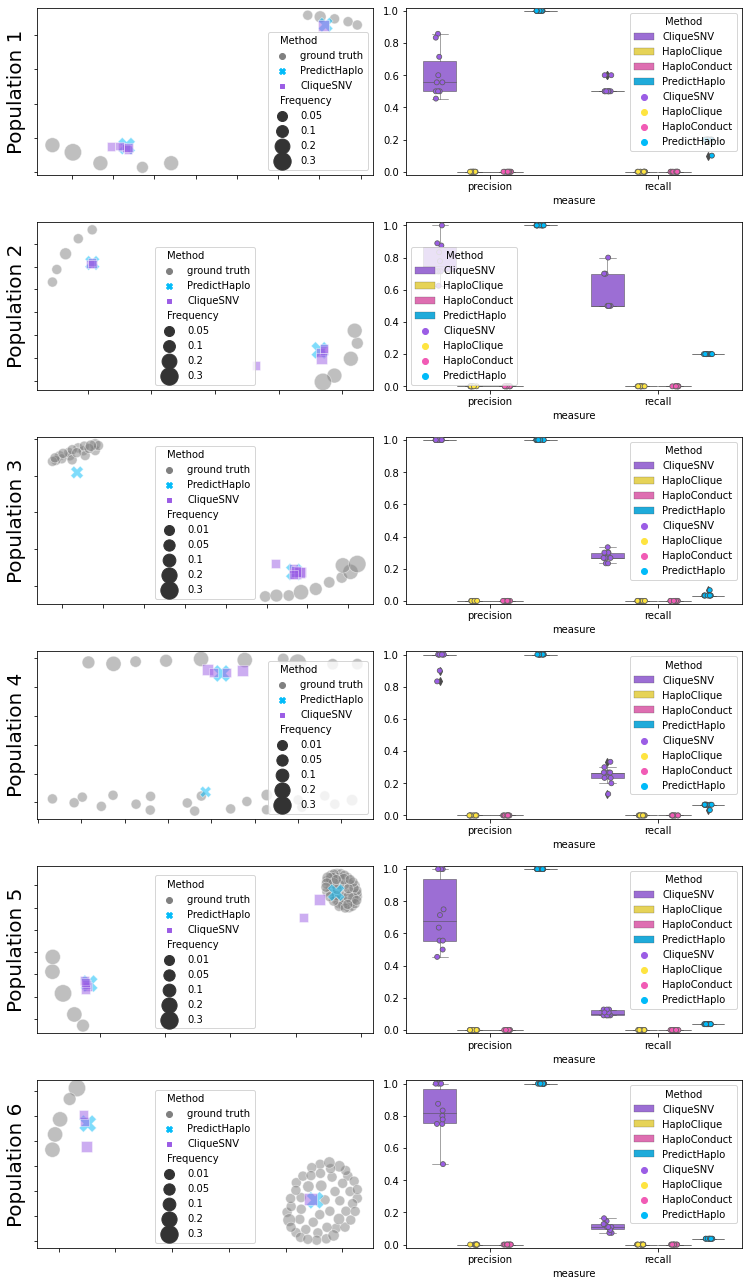

In [36]:
cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(6,2)

fig.set_figheight(18)
fig.set_figwidth(10.5)



order_mds = ["ground truth",  'PredictHaplo' , 'CliqueSNV']

for row_id, population in enumerate(order_population):
    dt_t = df_mds_plot[df_mds_plot["population"]==population]
    sns.scatterplot(
            data=dt_t.sort_values("Method",  key=np.vectorize(order_mds.index)), 
            x="MDS1", 
            y="MDS0", 
            size="Frequency",
            hue="Method", 
            hue_order= order_mds, 
            style_order = order_mds, 
            style="Method", 
            sizes=(100, 300),
            palette=method_palette,
            alpha=0.5,
            legend=True,  
            ax = ax[row_id][0],
            )

    ax[row_id][0].set_xticklabels("")
    ax[row_id][0].set_yticklabels("")
    ax[row_id][0].set_xlabel("")
    ax[row_id][0].set_ylabel(population, fontsize=20)
    
    dt_t = df[df["population"]==population]
    sns.boxplot(
            data=dt_t,
            x="measure",
            y="value",
            hue="Method",
            hue_order= method_order,
            palette=method_palette,
            width=0.8,
            linewidth=0.5,
            ax=ax[row_id][1], 
            
        )
    sns.stripplot(
        data=dt_t,
        x="measure",
        y="value",
        hue="Method", 
        hue_order= method_order,  
        palette=method_palette,  
        dodge=True,
        #clip_on=False,
        linewidth=0.8,
        edgecolor="gray",
        ax=ax[row_id][1],
    )

    ax[row_id][1].set_ylim(-0.02, 1.02)
    ax[row_id][1].set_ylabel("")
    
    #ax[row_id][1].get_legend().remove()
    
    
fig.tight_layout()

In [37]:
fig.savefig("./figures/Figure_4B_varyparams.svg")
